# Formalia:

Please read the [assignment overview page](https://github.com/SocialComplexityLab/socialgraphs2021/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc.), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday October the 31st, 2021 at 23:55. Hand in your IPython notebook file (with extension `.ipynb`) via http://peergrade.io/


(If you haven't set up an account on peergrade yet, go to www.peergrade.io/join and type in the class code: ***DPZEV6***.)

### Overview

This year's Assignment 2 is all about analyzing the network of rappers.

Note that this time I'm doing the exercises slightly differently in order to clean things up a bit. The issue is that the weekly lectures/exercises include quite a few instructions and intermediate results that are not quite something you guys can meaningfully answer. 

Therefore, in the assignment below, I have tried to reformulate the questions from the weekly exercises into something that is (hopefully) easier to answer. *Then I also note which lectures each question comes from*; that way, you can easily go back and find additional tips & tricks on how to solve things 😇


----

# Part 0: Building the network 

To create our network, we downloaded the rapper Wiki pages from each coast (during Week 4) and linked them via the hyperlinks connecting pages to each other. To achieve this goal we have used regular expressions.

> * Explain the strategy you have used to extract the hyperlinks from the Wiki-pages, assuming that you have already collected the rapper pages with the Wikipedia API.
> * Show the regular expressions you have built and explain in details how they work.

# Part 1: Network visualization and basic stats

Visualize your network of rappers (from lecture 5) and calculate stats (from lecture 4 and 5). For this exercise, we assume that you have already generated the network and extracted the largest weakly connected component (the "largest weakly connected component" of a directed network is the subgraph consisting of the nodes that would constitute the largest connected component if the network were undirected) . The visualization and statistics should be done for the largest weakly connected component only.

_Exercise 1a_: Stats (see lecture 4 and 5 for more hints)

> * What is the number of nodes in the network? 
> * What is the number of links?
> * Who is the top connected rapper? (Report results for the in-degrees and out-degrees). Comment on your findings. Is this what you would have expected?
> * Who are the top 5 most connected east-coast rappers (again in terms of in/out-degree)? 
> * Who are the top 5 most connected west-coast rappers (again in terms of in/out-degree)?
> * Plot the in- and out-degree distributions for the whole network. 
>   * Use axes that make sense for visualizing this particular distribution.
>   * What do you observe? 
>   * Give a pedagogical explaination of why the in-degree distribution is different from the out-degree distribution?
> * Find the exponent (by using the `powerlaw` package) for the in- and out-degree distributions. What does it say about our network?
> * Compare the two degree distributions two the degree distribution of a *random network* (undirected) with the same number of nodes and probability of connection *p*. Comment your results.

_Exercise 1b_: Visualization (see lecture 5 for more hints)

> * Create a nice visualization of the total (directed) network:
>   * Color nodes according to the role;
>   * Scale node-size according to degree;
>   * Get node positions based on either the Force Atlas 2 algorithm, or the built-in algorithms for networkX;
>   * Whatever else you feel like that would make the visualization nicer.
> * Describe the structure you observe. What useful information can you decipher from this?

# Part 2: Word-clouds

Create your own version of the word-clouds (from lecture 7). For this exercise we assume you know how to download and clean text from rappers' Wikipedia pages.

Here's what you need to do:
> * Create a word-cloud for each coast according to the novel TF-TR method. Feel free to make it as fancy as you like. Explain your process and comment on your results.
> * For each coast, what are the 5 words with the highest TR scores? Comment on your result.

In [5]:
# Download the wikipedia sources for this part

import pandas as pd
import re
import urllib.request as request
import urllib.parse
import numpy as np
import json
import os
import errno



def download_article_source(article_name: str):
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    title = "titles=" + urllib.parse.quote_plus(article_name)
    content = "prop=extracts"
    exlimit = "exlimit=1"
    explaintext = "explaintext=1"
    dataformat ="format=json"

    query = "{}{}&{}&{}&{}&{}&{}".format(baseurl, action, content, exlimit, explaintext, dataformat, title)
    print(query)

    wikiresponse = request.urlopen(query)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')

    json.loads(wikitext)

    # page content
    for _, value in json.loads(wikitext)["query"]["pages"].items():
         return value["extract"]
    
extracts = list()
list_file_names = list()
df_rappers = pd.read_csv("./Rappers.csv")

def download_rappers_from_file(df_rappers):
    """
    Download all articles in the indicated file and store them in files for later use.

    Parameters:
        df_rappers (DataFrame): data frame read from the csv file provided
        root_folder_path (string): folder into which the rapper files should be written. 
        Folder structure will be created if it does not exist.
    """


    for row in df_rappers.iterrows():
        entry = row[1]["WikipediaPageName"]
        entry = entry.replace(" ", "_")
        filename = "./rapper_files/" + row[1]["Coast"] + "/" + entry+".txt"

        # create directories if they do not exist
        if not os.path.exists(os.path.dirname(filename)):
            try:
                os.makedirs(os.path.dirname(filename))
            except OSError as exc: # Guard against race condition
                if exc.errno != errno.EEXIST:
                    raise

        list_file_names.append(entry+".txt")
        with open(filename, "+w") as file:
            file.write(download_article_source(entry))

download_rappers_from_file(df_rappers)

https://en.wikipedia.org/w/api.php?action=query&prop=extracts&exlimit=1&explaintext=1&format=json&titles=6ix9ine
https://en.wikipedia.org/w/api.php?action=query&prop=extracts&exlimit=1&explaintext=1&format=json&titles=9th_Prince
https://en.wikipedia.org/w/api.php?action=query&prop=extracts&exlimit=1&explaintext=1&format=json&titles=22Gz
https://en.wikipedia.org/w/api.php?action=query&prop=extracts&exlimit=1&explaintext=1&format=json&titles=38_Spesh
https://en.wikipedia.org/w/api.php?action=query&prop=extracts&exlimit=1&explaintext=1&format=json&titles=The_45_King
https://en.wikipedia.org/w/api.php?action=query&prop=extracts&exlimit=1&explaintext=1&format=json&titles=50_Cent
https://en.wikipedia.org/w/api.php?action=query&prop=extracts&exlimit=1&explaintext=1&format=json&titles=60_Second_Assassin_%28rapper%29
https://en.wikipedia.org/w/api.php?action=query&prop=extracts&exlimit=1&explaintext=1&format=json&titles=88-Keys
https://en.wikipedia.org/w/api.php?action=query&prop=extracts&exlim

In [6]:
# create text corpora and word frequency distributions for further work
import nltk.tokenize as tokenize
import nltk.corpus as corpus
import os
import nltk
wnl = nltk.WordNetLemmatizer()
from nltk.probability import FreqDist


# create corpora from downloaded sources, one for each coast
east_corpus = corpus.PlaintextCorpusReader("./rapper_files/East", os.listdir("./rapper_files/East"))
west_corpus = corpus.PlaintextCorpusReader("./rapper_files/West", os.listdir("./rapper_files/West"))


# extract words, exclude any non-alphanumeric characters (punctuations, etc.)
# and lemmatize words
east_words = [wnl.lemmatize(word.lower()) for word in east_corpus.words() if word.isalnum()]
west_words = [wnl.lemmatize(word.lower()) for word in west_corpus.words() if word.isalnum()]

# create frequency distributions
fdist_east = FreqDist(east_words)
fdist_west = FreqDist(west_words)

In [7]:
# create the TF-TR weights for each coast from the frequency distributions

most_common_east = fdist_east.most_common()
most_common_west = fdist_west.most_common()

c = 50

weighted_east = [(word, count / (fdist_west[word] + c)) for word, count in most_common_east]
weighted_east = sorted(weighted_east, key=lambda x: x[1], reverse=True)

weighted_west = [(word, count / (fdist_east[word] + c)) for word, count in most_common_west]
weighted_west = sorted(weighted_west, key=lambda x: x[1], reverse=True)

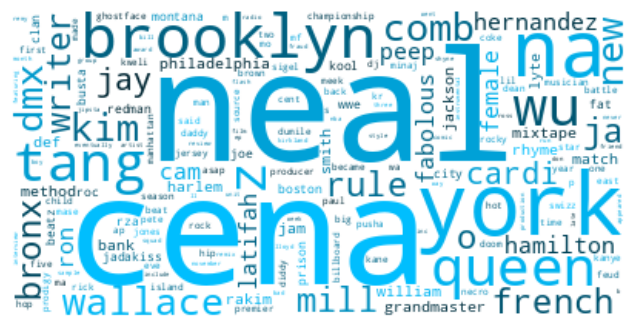

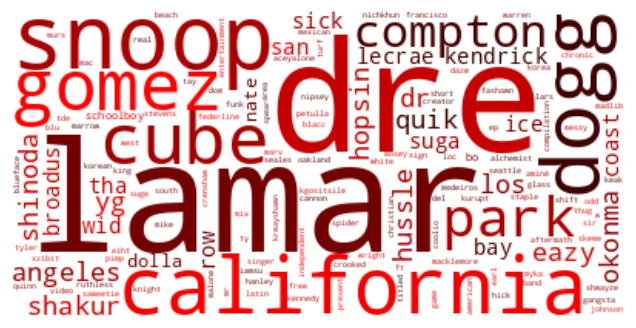

In [8]:
import wordcloud as wc
from wordcloud import WordCloud
from wordcloud import get_single_color_func
import matplotlib.pyplot as plt

cloud_text_east = str.join(" ", [word for word, counter in weighted_east for i in range (0, round(counter))])
cloud_text_west = str.join(" ", [word for word, counter in weighted_west for i in range (0, round(counter))])

def generate_wordcloud(text: str, colorfunc): 
    # to recreate colors: use color func described on this page: https://amueller.github.io/word_cloud/generated/wordcloud.get_single_color_func.html
    # and apply it as shown here: 
    wordcloud = WordCloud(collocations=False, background_color="white", max_font_size=100).generate(text)
    wordcloud = wordcloud.recolor(color_func=colorfunc)

    # Display the generated image:
    # the matplotlib way:

    plt.figure(figsize=(12,4))

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

generate_wordcloud(cloud_text_east, get_single_color_func('deepskyblue'))
generate_wordcloud(cloud_text_west, get_single_color_func('red'))

# Part 3: Communities

Find communities and their modularity (from lecture 7).

Here's what you need to do:
> * In your own words, explain what the measure "modularity" is, and the intuition behind the formula you use to compute it. 
> * Find communities in the network, and explain how you chose to identify the communities: Which algorithm did you use and how does it work?
> * Comment on your results:
>   * How many communities did you find in total?
>   * Compute the value of modularity with the partition created by the algorithm.
>   * Plot and/or print the distribution of community sizes (whichever makes most sense). Comment on your result.
> * Now, partition your rappers into two communities based on which coast they represent.
>   * What is the modularity of this partition? Comment on the result.

# Part 4: Sentiment of communities

Analyze the sentiment of communities (lecture 8). More tips & tricks can be found, if you take a look at Lecture 8's exercises.

A couple of additional instructions you will need below:
* Average the average sentiment of the nodes in each community to find a community-level sentiment.

Here's what you need to do (use the LabMT wordlist approach):
> * Calculate and store sentiment for every rapper
> * Create a histogram of all rappers' associated sentiments.
> * What are the 10 rappers with happiest and saddest pages?

Now, compute the sentiment of each coast: 
> * Which is the happiest and which is saddest coast according to the LabMT wordlist approach? (Take the coast's sentiment to be the average sentiment of the coast's rappers' pages (disregarding any rappers with sentiment 0).
> * Use the "label shuffling test" (Week 5 and 8) to test if the coast with the highest wikipedia page sentiment has a page sentiment that is significantly higher (5% confidence bound) than a randomly selected group of rappers of the same size.
> * Does the result make sense to you? Elaborate.

**Congratulations for making it to the end of the Assignment. Good luck with your independent project**

